In [2]:
# Snowpark
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.functions import pandas_udf

# Pandas & json
import pandas as pd
import numpy as np
import json

# Plotting
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns


# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# %matplotlib inline|

In [3]:
# Read credentials
with open('creds.json') as f:
    connection_parameters = json.load(f)    
session = Session.builder.configs(connection_parameters).create()

In [4]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "HOUSING"
Schema                      : "PUBLIC"
Warehouse                   : "XSMALL_WH"
Role                        : "ACCOUNTADMIN"
Snowpark for Python version : 1.0.0


# EXTRACT FROM S3

In [10]:
import requests
from zipfile import ZipFile
from io import BytesIO
import os

from datetime import datetime

download_base_url = "https://s3.amazonaws.com/damgbucket/project/"
file_name_end = '_Melbourne_housing_FULL.csv.zip'
date_range = pd.period_range(start=datetime.strptime("2016", "%Y"), 
                             end=datetime.strptime("2017", "%Y"), 
                             freq='Y').strftime("%Y")

schema_files_to_download = [date+file_name_end and date+file_name_end for date in date_range.to_list()]
files_to_download = list(schema_files_to_download)
print(schema_files_to_download)

schema_files_to_load = list()
for file_name in schema_files_to_download:
    url = download_base_url+file_name
    print('Downloading and unzipping: '+url)
    r = requests.get(url)
    file = ZipFile(BytesIO(r.content))
    csv_file_name=file.namelist()[0]
    schema_files_to_load.append(csv_file_name)
    file.extract(csv_file_name)
    file.close()

files_to_load = {'schema': schema_files_to_load}


['2016_Melbourne_housing_FULL.csv.zip', '2017_Melbourne_housing_FULL.csv.zip']


In [8]:

def extract_to_stage(session, files_to_download: list, download_base_url: str):
    import requests
    from zipfile import ZipFile
    from io import BytesIO
    import os

    from datetime import datetime

    file_name_end = '_Melbourne_housing_FULL.csv.zip'
    date_range = pd.period_range(start=datetime.strptime("2016", "%Y"), 
                                 end=datetime.strptime("2017", "%Y"), 
                                 freq='Y').strftime("%Y")

    schema_files_to_download = [date+file_name_end and date+file_name_end for date in date_range.to_list()]
    files_to_download = list(schema_files_to_download)
    print(schema_files_to_download)

    schema_files_to_load = list()
    for file_name in schema_files_to_download:
        url = download_base_url+file_name
        print('Downloading and unzipping: '+url)
        r = requests.get(url)
        file = ZipFile(BytesIO(r.content))
        csv_file_name=file.namelist()[0]
        schema_files_to_load.append(csv_file_name)
        file.extract(csv_file_name)
        file.close()

    files_to_load = {'schema': schema_files_to_load}
    
    return files_to_load


# LOAD

In [135]:
df_2016 = pd.read_csv(files_to_load['schema'][0])
df_2017 = pd.read_csv(files_to_load['schema'][1])

df = pd.concat([df_2016,df_2017])
df.head()

,Date,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date.1,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,2016-01-28,Surrey Hills,999A Riversdale Rd,3,h,1205000.0,S,Fletchers,2016-01-28,11.2,...,1.0,2.0,490.0,NaN,NaN,Boroondara City Council,-37.8361,145.1006,Southern Metropolitan,5457.0
1,2016-01-28,Surrey Hills,1/10 Florence Rd,2,u,813000.0,S,Fletchers,2016-01-28,11.2,...,1.0,2.0,108.0,NaN,NaN,Boroondara City Council,-37.8276,145.1023,Southern Metropolitan,5457.0
2,2016-01-28,Canterbury,140 Canterbury Rd,4,h,NaN,SP,Fletchers,2016-01-28,9.0,...,2.0,0.0,808.0,198.0,1910.0,Boroondara City Council,-37.8235,145.0751,Southern Metropolitan,3265.0
3,2016-03-09,Williamstown,54 Twyford St,3,h,1535000.0,S,Greg,2016-03-09,8.0,...,1.0,1.0,507.0,186.0,1910.0,Hobsons Bay City Council,-37.8681,144.8994,Western Metropolitan,6380.0
4,2016-03-09,Newport,1/26 Thorpe St,3,h,826000.0,S,Village,2016-03-09,8.4,...,1.0,2.0,281.0,100.0,1957.0,Hobsons Bay City Council,-37.8457,144.8651,Western Metropolitan,5498.0


In [136]:
snowdf = session.createDataFrame(df)
snowdf.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2016-01-28  |Surrey Hills  |999A Rivers

In [137]:

snowdf.write.mode("overwrite").saveAsTable("housingprice") 

session.table("housingprice").show(5)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2016-01-28  |Surrey Hills  |999A Rivers

In [138]:
# Create a pandas data frame from the Snowflake table
mel_df = session.table('housingprice').toPandas() 

print(f"'mel_df' local dataframe created. Number of records: {len(mel_df)} ")

'mel_df' local dataframe created. Number of records: 30144 


In [139]:
mel_df.head()

,Date,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date.1,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,2016-01-28,Surrey Hills,999A Riversdale Rd,3,h,1205000.0,S,Fletchers,2016-01-28,11.2,...,1.0,2.0,490.0,NaN,NaN,Boroondara City Council,-37.8361,145.1006,Southern Metropolitan,5457.0
1,2016-01-28,Surrey Hills,1/10 Florence Rd,2,u,813000.0,S,Fletchers,2016-01-28,11.2,...,1.0,2.0,108.0,NaN,NaN,Boroondara City Council,-37.8276,145.1023,Southern Metropolitan,5457.0
2,2016-01-28,Canterbury,140 Canterbury Rd,4,h,NaN,SP,Fletchers,2016-01-28,9.0,...,2.0,0.0,808.0,198.0,1910.0,Boroondara City Council,-37.8235,145.0751,Southern Metropolitan,3265.0
3,2016-03-09,Williamstown,54 Twyford St,3,h,1535000.0,S,Greg,2016-03-09,8.0,...,1.0,1.0,507.0,186.0,1910.0,Hobsons Bay City Council,-37.8681,144.8994,Western Metropolitan,6380.0
4,2016-03-09,Newport,1/26 Thorpe St,3,h,826000.0,S,Village,2016-03-09,8.4,...,1.0,2.0,281.0,100.0,1957.0,Hobsons Bay City Council,-37.8457,144.8651,Western Metropolitan,5498.0


In [11]:
def load(session):
    import pandas as pd
    df_2016 = pd.read_csv(files_to_load['schema'][0])
    df_2017 = pd.read_csv(files_to_load['schema'][1])

    df = pd.concat([df_2016,df_2017])
    df.head()

    snowdf = session.createDataFrame(df)
    snowdf.show()

    snowdf.write.mode("overwrite").saveAsTable("housingprice") 
    session.table("housingprice").show(5)

    # Create a pandas data frame from the Snowflake table
    mel_df = session.table('housingprice').toPandas() 
    print(f"'mel_df' local dataframe created. Number of records: {len(mel_df)} ")

In [12]:
load(session=session)

create_temp_table is deprecated. We still respect this parameter when it is True but please consider using `table_type="temporary"` instead.


-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2016-01-28  |Surrey Hills  |999A Rivers

# FUNCTIONS

In [ ]:
def extract_to_stage(session, files_to_download: list, download_base_url: str):
    
    import requests
    from io import BytesIO
    from zipfile import ZipFile

    files_to_load = list()
    url = download_base_url + file_name
    print('Downloading and unzipping : '+url)
    r = requests.get(url)
    file = ZipFile(BytesIO(r.content))
    csv_file_name=file.namelist()[0]
    files_to_load.append(csv_file_name)
    file.extract(csv_file_name)
    file.close()

    return files_to_load

In [ ]:
files_to_download

'2016_Melbourne_housing_FULL.csv.zip'

In [12]:
extract_to_stage(session=session, 
                files_to_download=files_to_download, 
                download_base_url=download_base_url)

['2016_Melbourne_housing_FULL.csv.zip', '2017_Melbourne_housing_FULL.csv.zip']


{'schema': ['2016_Melbourne_housing_FULL.csv',
  '2017_Melbourne_housing_FULL.csv']}

In [17]:
def bulk_elt(session, 
             download_base_url) -> str:
    
    import requests
    from io import BytesIO
    from zipfile import ZipFile
    extract_to_stage(session=session, 
                files_to_download=files_to_download, 
                download_base_url=download_base_url)
    
    import pandas as pd
    stage_table_names = load(session=session)
    
    return stage_table_names
    

In [18]:
bulk_elt(session=session,  
         download_base_url='https://s3.amazonaws.com/damgbucket/project/')

['2016_Melbourne_housing_FULL.csv.zip', '2017_Melbourne_housing_FULL.csv.zip']
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# INCREMENTAL ELT

In [16]:
import requests
from zipfile import ZipFile
from io import BytesIO
import os

from datetime import datetime

file_name_end = '_Melbourne_housing_FULL.csv.zip'

date_range = pd.period_range(start=datetime.strptime("2016", "%Y"), 
                             end=datetime.now(), 
                             freq='Y').strftime("%Y")
daterange=date_range.to_list()
length=len(daterange)
print(daterange[length-1])

schema_files_to_download_1 = [daterange[length-5]+file_name_end]

# schema_files_to_download = [date+file_name_end and date+file_name_end for date in date_range.to_list()]
files_to_download = list(schema_files_to_download_1)
print(schema_files_to_download_1)

schema_files_to_load = list()
for file_name in schema_files_to_download_1:
    url = download_base_url+file_name
    print('Downloading and unzipping: '+url)
    r = requests.get(url)
    file = ZipFile(BytesIO(r.content))
    csv_file_name=file.namelist()[0]
    schema_files_to_load.append(csv_file_name)
    file.extract(csv_file_name)
    file.close()

files_to_load_final = {'schema': schema_files_to_load}
files_to_load_final


2022
['2018_Melbourne_housing_FULL.csv.zip']


{'schema': ['2018_Melbourne_housing_FULL.csv']}

In [13]:
def inc_extract(session, download_base_url: str):
    import requests
    from zipfile import ZipFile
    from io import BytesIO
    import os

    from datetime import datetime

    file_name_end = '_Melbourne_housing_FULL.csv.zip'
    date_range = pd.period_range(start=datetime.strptime("2016", "%Y"), 
                                 end=datetime.now(), 
                                 freq='Y').strftime("%Y")
    daterange=date_range.to_list()
    length=len(daterange)

    schema_files_to_download_1 = [daterange[length-5]+file_name_end]
    files_to_download = list(schema_files_to_download_1)
    print(schema_files_to_download_1)

    schema_files_to_load = list()
    for file_name in schema_files_to_download_1:
        url = download_base_url+file_name
        print('Downloading and unzipping: '+url)
        r = requests.get(url)
        file = ZipFile(BytesIO(r.content))
        csv_file_name=file.namelist()[0]
        schema_files_to_load.append(csv_file_name)
        file.extract(csv_file_name)
        file.close()

    files_to_load_final = {'schema': schema_files_to_load}
    files_to_load_final

    return files_to_load_final


In [14]:
inc_extract(session=session,download_base_url=download_base_url)

['2018_Melbourne_housing_FULL.csv.zip']


{'schema': ['2018_Melbourne_housing_FULL.csv']}

In [17]:
files_to_load_final['schema'][0]

'2018_Melbourne_housing_FULL.csv'

In [18]:
import pandas as pd
inc_df = pd.read_csv(files_to_load_final['schema'][0])

mel_df = session.table('housingprice').toPandas() 
housing_price=pd.concat([mel_df,inc_df])

print(f"'housing_price' local dataframe created. Number of records: {len(housing_price)} ")
snowdf_housing_price = session.createDataFrame(housing_price)
snowdf_housing_price.write.mode("overwrite").saveAsTable("housingprice") 
session.table("housingprice").limit(5).show(5)

# Create a pandas data frame from the Snowflake table
mel_inc_df = session.table('housingprice').toPandas() 
print(f"'mel_inc_df' local dataframe created. Number of records: {len(mel_inc_df)} ")



'housing_price' local dataframe created. Number of records: 34857 
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
def inc_extract(session, download_base_url: str):
    import requests
    from zipfile import ZipFile
    from io import BytesIO
    import os

    from datetime import datetime

    file_name_end = '_Melbourne_housing_FULL.csv.zip'
    date_range = pd.period_range(start=datetime.strptime("2017", "%Y"), 
                                 end=datetime.strptime("2018", "%Y"), 
                                 freq='Y').strftime("%Y")

    schema_files_to_download = [date+file_name_end and date+file_name_end for date in date_range.to_list()]
    files_to_download = list(schema_files_to_download)
    print(schema_files_to_download)

    schema_files_to_load = list()
    for file_name in schema_files_to_download:
        url = download_base_url+file_name
        print('Downloading and unzipping: '+url)
        r = requests.get(url)
        file = ZipFile(BytesIO(r.content))
        csv_file_name=file.namelist()[0]
        schema_files_to_load.append(csv_file_name)
        file.extract(csv_file_name)
        file.close()

    files_to_load_final = {'schema': schema_files_to_load}
    
    return files_to_load_final


In [146]:
def inc_load(files_to_load_final: dict):
    import pandas as pd
    inc_df = pd.read_csv(files_to_load_final['schema'][0])
    mel_df = session.table('housingprice').toPandas() 
    housing_price=pd.concat([mel_df,inc_df])

    print(f"'housing_price' local dataframe created. Number of records: {len(housing_price)} ")
    snowdf_housing_price = session.createDataFrame(housing_price)
    snowdf_housing_price.write.mode("overwrite").saveAsTable("housingprice") 
    session.table("housingprice").limit(5).show(5)

    # Create a pandas data frame from the Snowflake table
    mel_inc_df = session.table('housingprice').toPandas() 
    print(f"'mel_inc_df' local dataframe created. Number of records: {len(mel_inc_df)} ")

In [25]:
inc_load(files_to_load_final=files_to_load_final)

'housing_price' local dataframe created. Number of records: 34857 
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"Date"      |"Suburb"      |"Address"           |"Rooms"  |"Type"  |"Price"    |"Method"  |"SellerG"  |"Date.1"    |"Distance"  |"Postcode"  |"Bedroom2"  |"Bathroom"  |"Car"  |"Landsize"  |"BuildingArea"  |"YearBuilt"  |"CouncilArea"             |"Lattitude"  |"Longtitude"  |"Regionname"           |"Propertycount"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# EDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
session.sql("SELECT count(*) FROM HOUSING.PUBLIC.HOUSINGPRICE").collect()

[Row(COUNT(*)=30144)]

In [21]:
housepricingdf = session.table("HOUSING.PUBLIC.HOUSINGPRICE")

In [22]:
housepricingdf=housepricingdf.to_pandas()


In [23]:
housepricingdf.shape

(30144, 22)

# CLEARING THE DATA AND PRE-PROCESSING

In [25]:
# Count of the missing values of the dataset
count_NaN = housepricingdf.isna().sum()
count_NaN

Date                 0
Suburb               0
Address              0
Rooms                0
Type                 0
Price             6571
Method               0
SellerG              0
Date.1               0
Distance             0
Postcode             0
Bedroom2          6817
Bathroom          6823
Car               7162
Landsize         10066
BuildingArea     17997
YearBuilt        16317
CouncilArea          2
Lattitude         6600
Longtitude        6600
Regionname           2
Propertycount        2
dtype: int64

In [11]:
housepricingdf.nunique()

Date                68
Suburb             346
Address          29486
Rooms               12
Type                 3
Price             2722
Method               9
SellerG            363
Date.1              68
Distance           213
Postcode           208
Bedroom2            15
Bathroom            11
Car                 14
Landsize          1631
BuildingArea       721
YearBuilt          156
CouncilArea         33
Lattitude        11161
Longtitude       12203
Regionname           8
Propertycount      339
dtype: int64

In [27]:
# Filling the missing Car values with the mean of the Car value which is 1
housepricingdf['Car'].fillna(np.floor(housepricingdf['Car'].mean()), inplace=True)

# Filling the missing Car values with the mean of the Car value which is 1
housepricingdf['BuildingArea'].fillna(np.floor(housepricingdf['BuildingArea'].mean()), inplace=True)

# Filling the missing Car values with the mean of the Car value which is 1
housepricingdf['Landsize'].fillna(np.floor(housepricingdf['Landsize'].mean()), inplace=True)

# Filling the missing Car values with the mean of the Car value which is 1
housepricingdf['Price'].fillna(np.floor(housepricingdf['Price'].mean()), inplace=True)

# Filling the missing Car values with the mean of the Car value which is 1
housepricingdf['Bathroom'].fillna(np.floor(housepricingdf['Bathroom'].mean()), inplace=True)

In [28]:
# # Dropping the highly NaN and not needed columns. BuildingArea, YearBuilt.
# housepricingdf = housepricingdf.dropna(subset=['YEARBUILT'], axis=0)

In [29]:
# Count of the missing values of the dataset
count_NaN = housepricingdf.isna().sum()
count_NaN

Date                 0
Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date.1               0
Distance             0
Postcode             0
Bedroom2          6817
Bathroom             0
Car                  0
Landsize             0
BuildingArea         0
YearBuilt        16317
CouncilArea          2
Lattitude         6600
Longtitude        6600
Regionname           2
Propertycount        2
dtype: int64

In [30]:

cols_zero = ['Propertycount','YearBuilt','Distance','Regionname','CouncilArea', 'Lattitude', 'Longtitude' ]
housepricingdf[cols_zero]=housepricingdf[cols_zero].fillna(0)


In [31]:
# Identify object columns
print(housepricingdf.select_dtypes(['object']).columns)

Index(['Date', 'Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date.1',
       'CouncilArea', 'Regionname'],
      dtype='object')


In [32]:
# Convert objects to categorical variables
obj_cats = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea','Regionname']

for colname in obj_cats:
    housepricingdf[colname] = housepricingdf[colname].astype('category')  

In [33]:
housepricingdf.shape

(30144, 22)

In [36]:
# Drop columns
housepricingdf = housepricingdf.drop(['Bedroom2'],1)
housepricingdf = housepricingdf.drop(['Date.1'],1)

/var/folders/t3/g34fqy5x7g93yy85dp44j8700000gn/T/ipykernel_46324/3416558378.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  housepricingdf = housepricingdf.drop(['Date.1'],1)


In [38]:
housepricingdf.shape

(30144, 20)

In [39]:
# Identify categorical features
housepricingdf.select_dtypes(['category']).columns

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea',
       'Regionname'],
      dtype='object')

In [40]:
# Identify numeric features
housepricingdf.select_dtypes(['float64','int64']).columns

Index(['Price', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize',
       'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Propertycount'],
      dtype='object')

/var/folders/t3/g34fqy5x7g93yy85dp44j8700000gn/T/ipykernel_46324/437456995.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housepricingdf['Price'], kde=True, bins=40).set_title('Figure 3B: Histogram of Price', fontsize = 15)


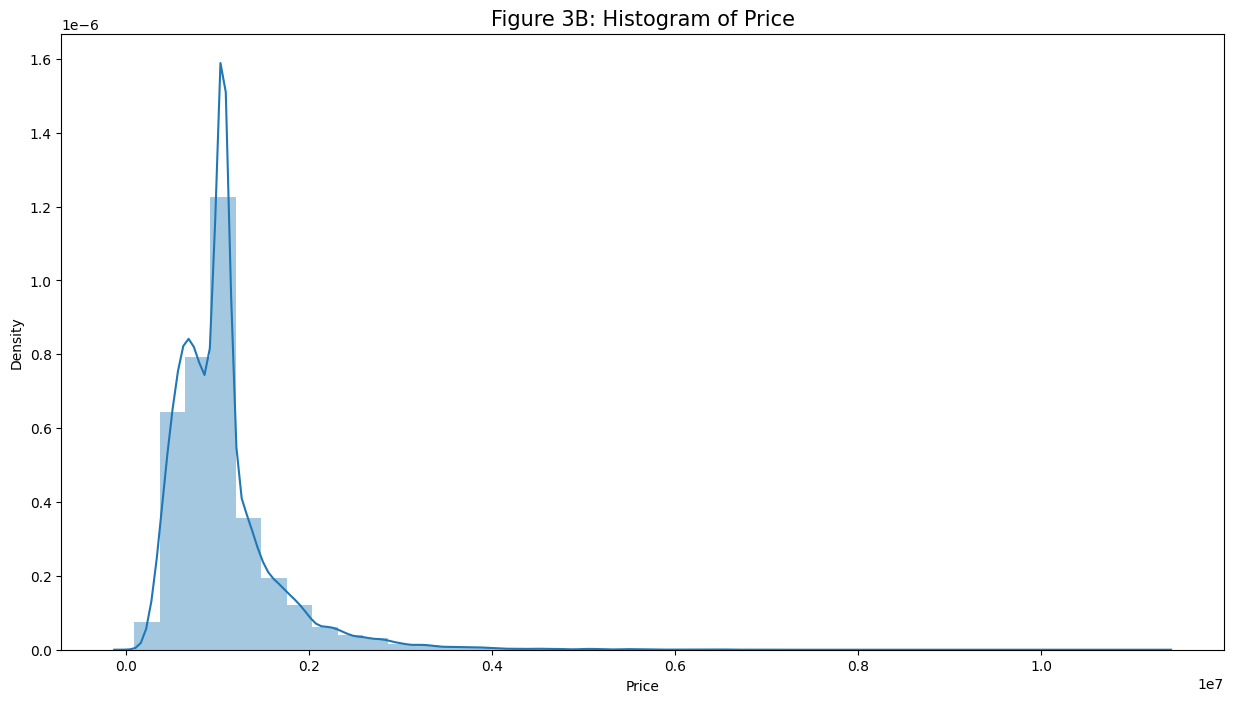

In [41]:
# Boxplot of Price
plt.figure(figsize = (15,8))
sns.distplot(housepricingdf['Price'], kde=True, bins=40).set_title('Figure 3B: Histogram of Price', fontsize = 15)
plt.show();

In [42]:
housepricingdf['Price'].skew()

2.9225848456128682

In [50]:
housepricingdf.head()

,Date,Suburb,Address,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,2016-01-28,Surrey Hills,999A Riversdale Rd,3,h,1205000.0,S,Fletchers,11.2,3127.0,1.0,2.0,490.0,158.0,0.0,Boroondara City Council,-37.8361,145.1006,Southern Metropolitan,5457.0
1,2016-01-28,Surrey Hills,1/10 Florence Rd,2,u,813000.0,S,Fletchers,11.2,3127.0,1.0,2.0,108.0,158.0,0.0,Boroondara City Council,-37.8276,145.1023,Southern Metropolitan,5457.0
2,2016-01-28,Canterbury,140 Canterbury Rd,4,h,1055272.0,SP,Fletchers,9.0,3126.0,2.0,0.0,808.0,198.0,1910.0,Boroondara City Council,-37.8235,145.0751,Southern Metropolitan,3265.0
3,2016-03-09,Williamstown,54 Twyford St,3,h,1535000.0,S,Greg,8.0,3016.0,1.0,1.0,507.0,186.0,1910.0,Hobsons Bay City Council,-37.8681,144.8994,Western Metropolitan,6380.0
4,2016-03-09,Newport,1/26 Thorpe St,3,h,826000.0,S,Village,8.4,3015.0,1.0,2.0,281.0,100.0,1957.0,Hobsons Bay City Council,-37.8457,144.8651,Western Metropolitan,5498.0


/var/folders/t3/g34fqy5x7g93yy85dp44j8700000gn/T/ipykernel_46324/2688947462.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housepricingdf['Landsize'], hist=True, color='blue')


Text(0.5, 1.0, 'Density Plot of the Landsize')

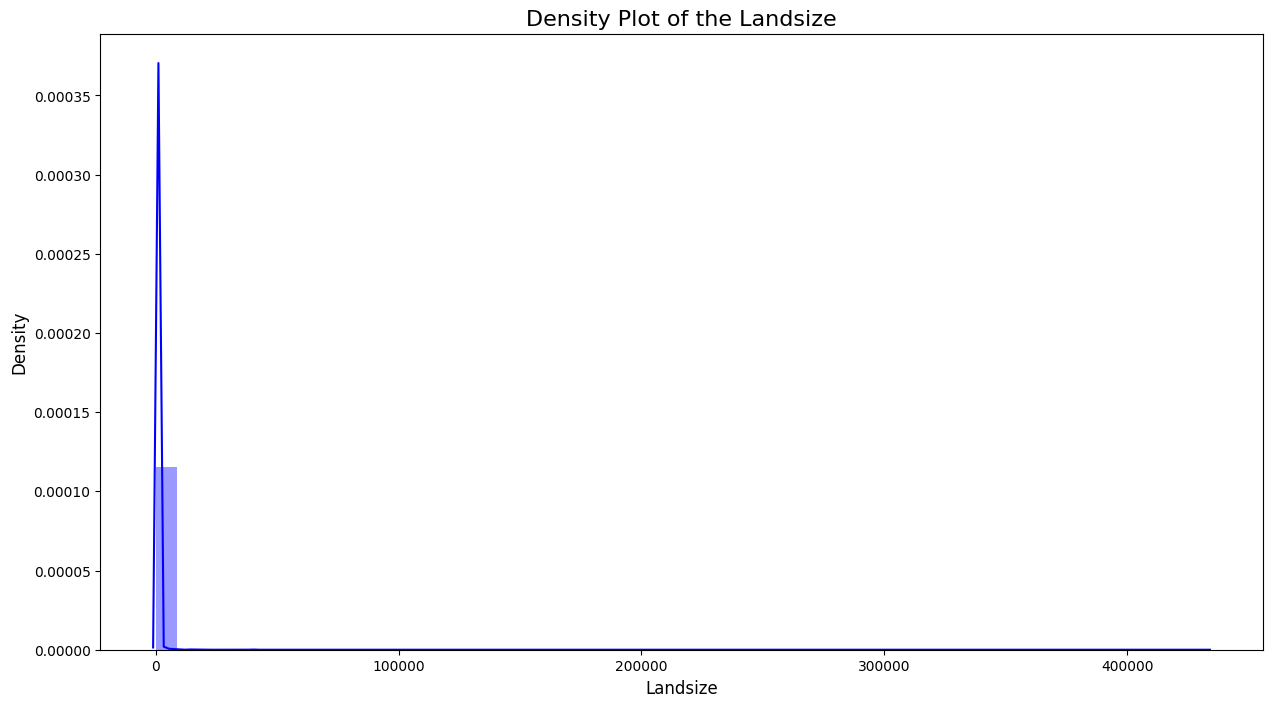

In [43]:
# Density Plot of the Landsize
plt.figure(figsize=(15, 8))
sns.distplot(housepricingdf['Landsize'], hist=True, color='blue')
plt.ylabel('Density',fontsize=12)
plt.xlabel("Landsize", fontsize=12)
plt.title("Density Plot of the Landsize", fontsize=16)

As seen from the Density Plot of the Landsize, the X-axis represents that the house Landsizes and the Y-axis represents that the Density of the Density of the Landsizes. According to the graph, the house prices have high density between the 0 values.

/var/folders/t3/g34fqy5x7g93yy85dp44j8700000gn/T/ipykernel_46324/2409086882.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housepricingdf['Distance'], hist=True, color='green')


Text(0.5, 1.0, 'Density Plot of the Distance from CBD')

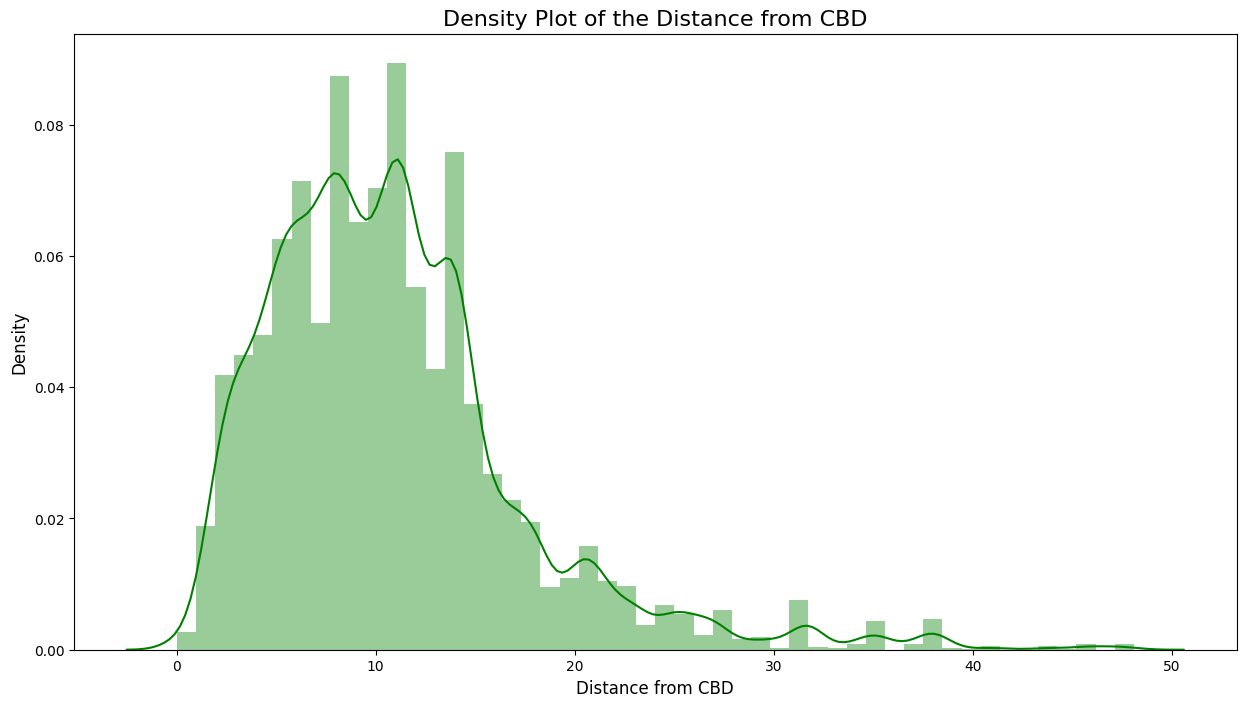

In [44]:
# Density Plot of the Distance from CBD (Central Business Sub District)
plt.figure(figsize=(15, 8))
sns.distplot(housepricingdf['Distance'], hist=True, color='green')
plt.ylabel('Density',fontsize=12)
plt.xlabel("Distance from CBD", fontsize=12)
plt.title("Density Plot of the Distance from CBD", fontsize=16)

In the figure above, the X-axis represents that the Distance from CBD and CBD reffers that the Central Business Sub District. The Y-axis represents that the Density of the Distance from CBD. According to this graph, the most of the houses are close to the Central Business Sub District.

/var/folders/t3/g34fqy5x7g93yy85dp44j8700000gn/T/ipykernel_46324/3688088236.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housepricingdf['Rooms'], hist=True, color='purple')


Text(0.5, 1.0, 'Density Plot of the Rooms')

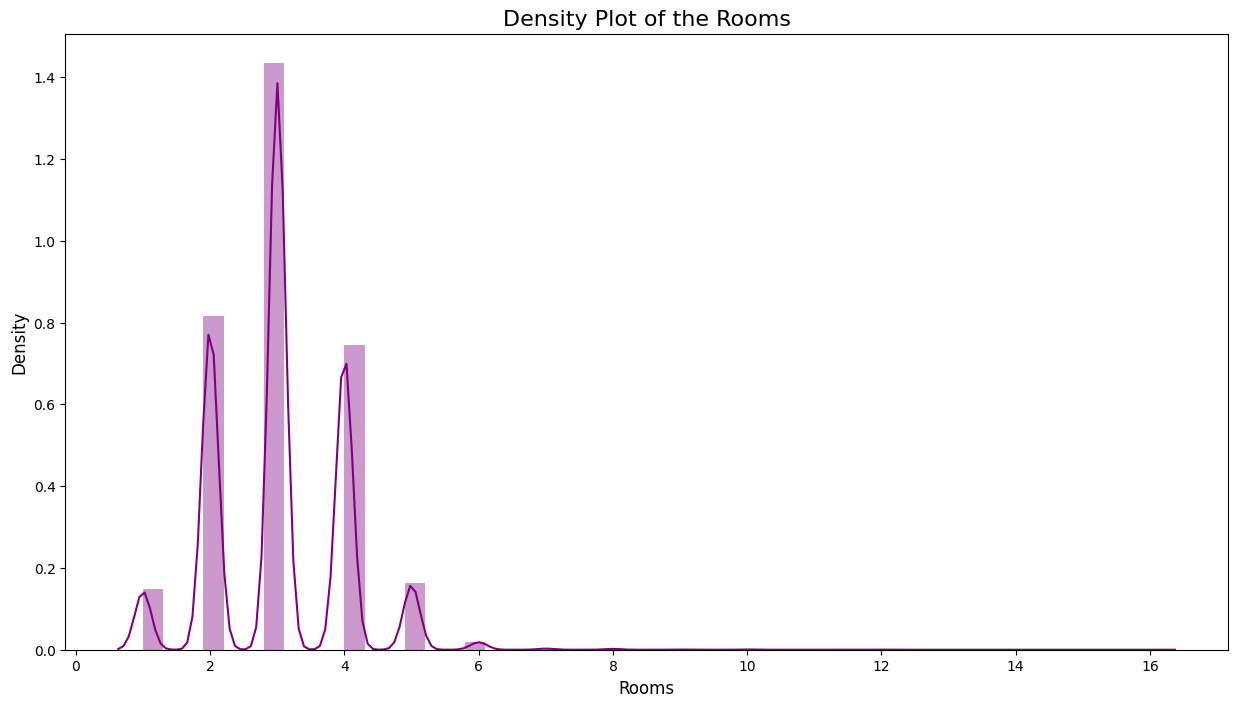

In [45]:
# Density Plot of the Rooms
plt.figure(figsize=(15, 8))
sns.distplot(housepricingdf['Rooms'], hist=True, color='purple')
plt.ylabel('Density',fontsize=12)
plt.xlabel("Rooms", fontsize=12)
plt.title("Density Plot of the Rooms", fontsize=16)

In the figure above, the X-axis represents that the Rooms of the houses. And the Y-axis represents that the Density of the Rooms. According to this graph, the most of the houses have 2, 3 or4 rooms but the 3 rooms have the majority.

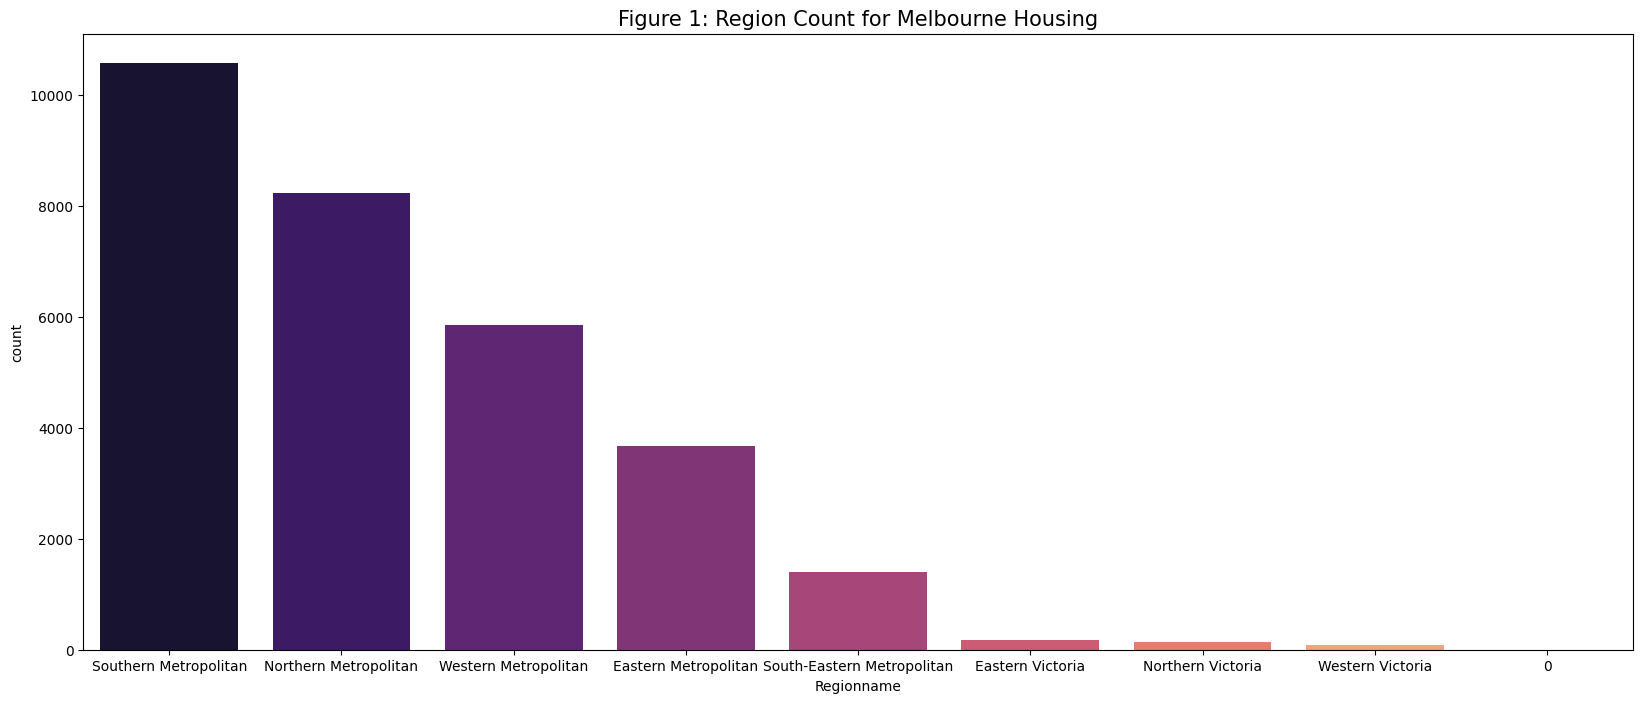

In [46]:
plt.figure(figsize = (20,8))
fig = sns.countplot(x = 'Regionname', data = housepricingdf, palette = 'magma', 
                    order = housepricingdf['Regionname'].value_counts().index)
fig = plt.title('Figure 1: Region Count for Melbourne Housing', fontsize = 15)
plt.show()

Text(0.5, 0, 'Regionnames')

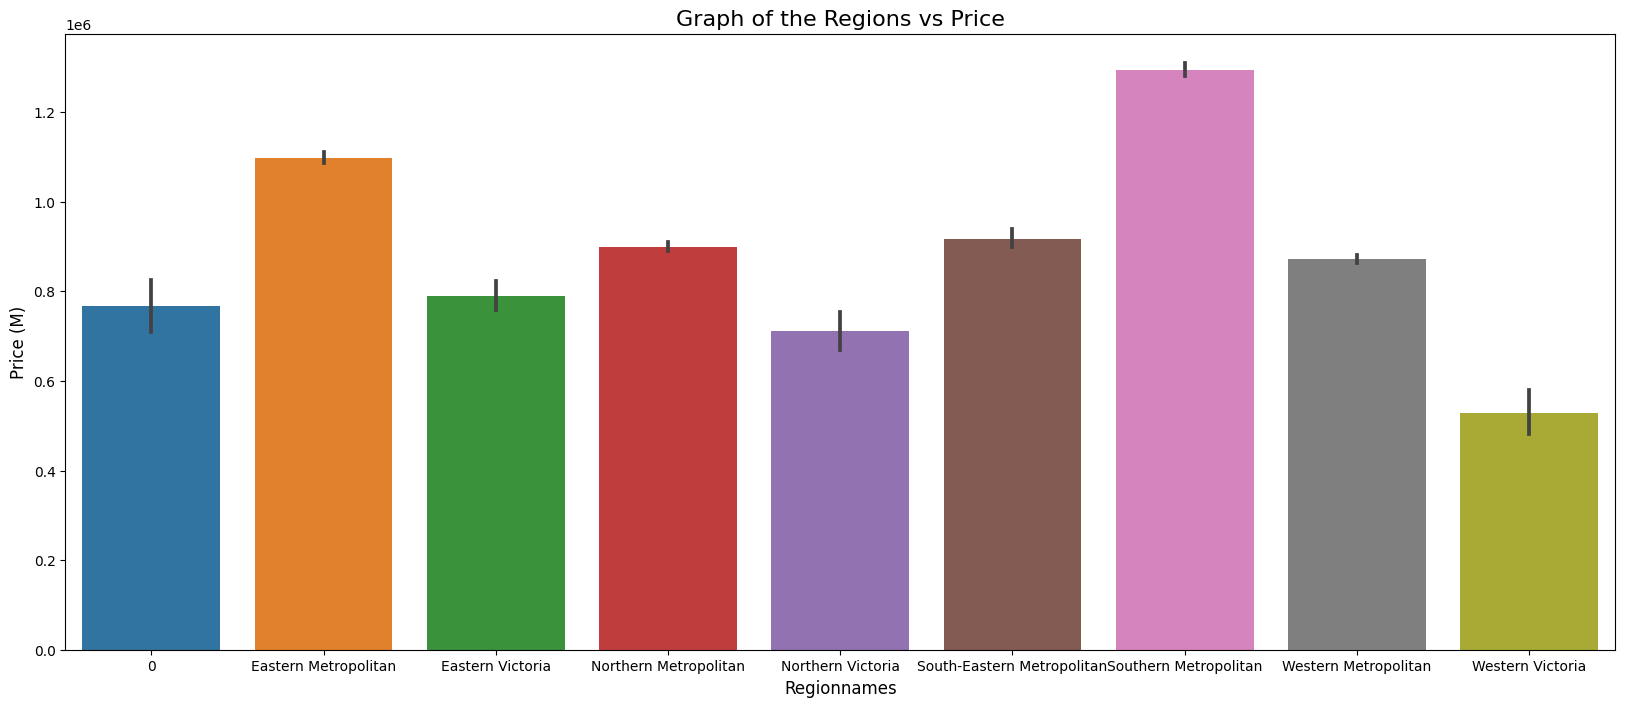

In [48]:
# Regions vs Price barplot
plt.figure(figsize=(20, 8))
sns.barplot(x=housepricingdf['Regionname'], y=housepricingdf['Price'])
plt.title("Graph of the Regions vs Price", fontsize=16)
plt.ylabel('Price (M)', fontsize=12)
plt.xlabel('Regionnames', fontsize=12)


The figure above shows that the Graph of the Regions vs House Prices. The X-axis represents that the Region names and the Y-axis represent that the price of the houses. According to this graph, the Southern Metropolitan has the highest total house prices. This does not mean that the most expensive houses are located there. As you can see from the Density of the Region names, the Southern Metropolitan had the highest density.

Hence, the highest price of the Southern Metropolitan may not refer that the Southern Metropolitan is the most expensive region.

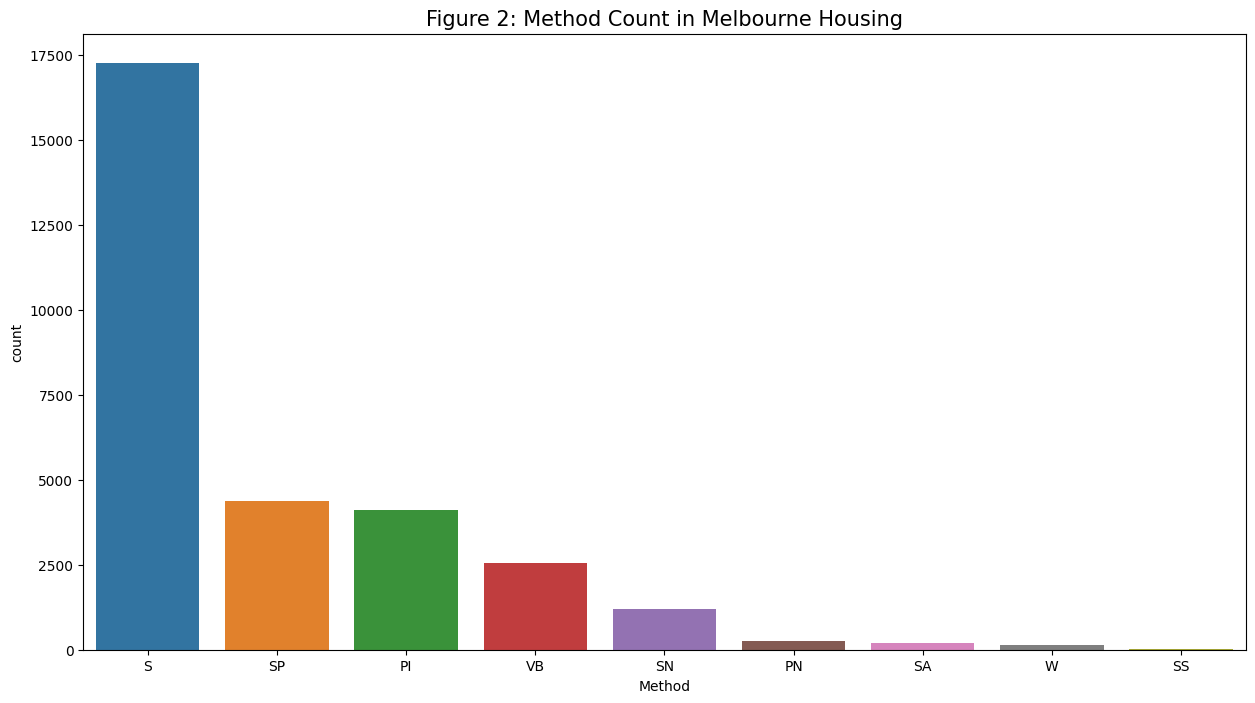

In [49]:
plt.figure(figsize = (15,8))
fig = sns.countplot(x = 'Method', data = housepricingdf, palette = None, 
                    order = housepricingdf['Method'].value_counts().index)
fig = plt.title('Figure 2: Method Count in Melbourne Housing', fontsize = 15)
plt.show()

# TWO VARIABLE VISUALIZATION

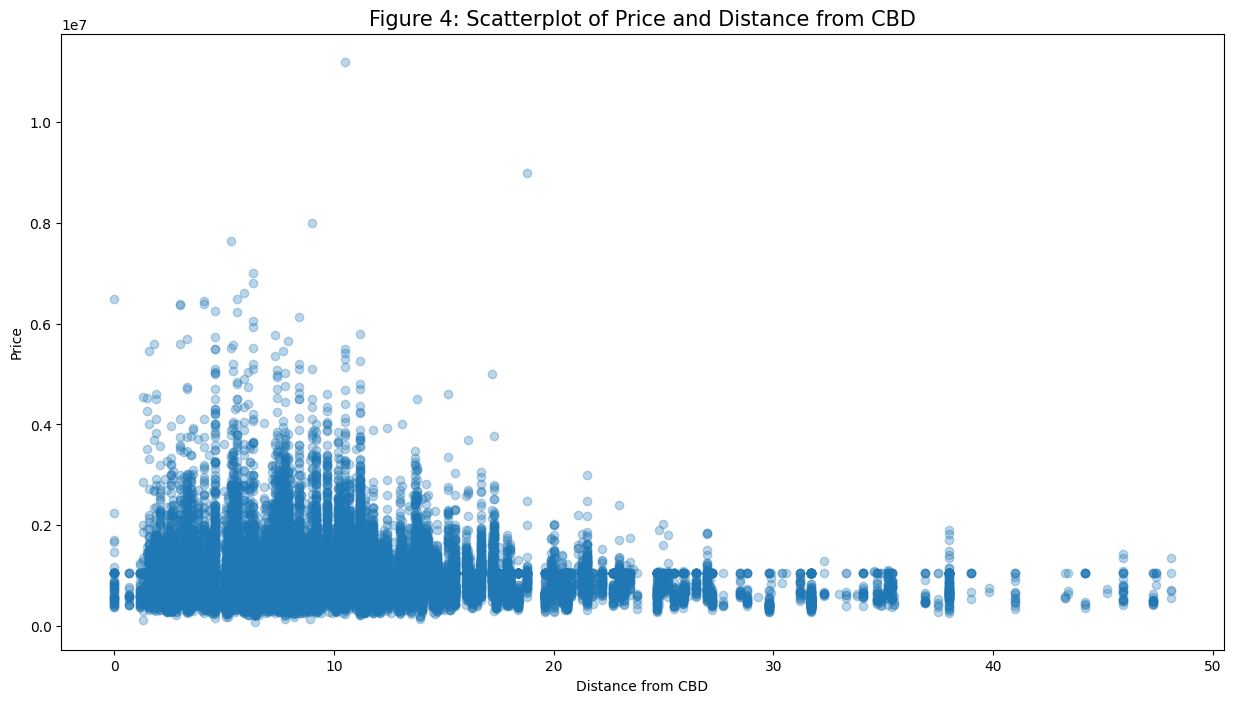

In [51]:
plt.figure(figsize = (15,8))
plt.scatter(housepricingdf['Distance'], housepricingdf['Price'], alpha = 0.3)
plt.title('Figure 4: Scatterplot of Price and Distance from CBD', fontsize = 15)
plt.xlabel('Distance from CBD')
plt.ylabel('Price')
plt.show();

shows that there is a correlation between the distance from CBD and price. As the distance increases, the price tends to be lower.

In [52]:
# Creating a new dataset with the Latitude and Longitude
latitude = housepricingdf['Lattitude']
longitude = housepricingdf['Longtitude']


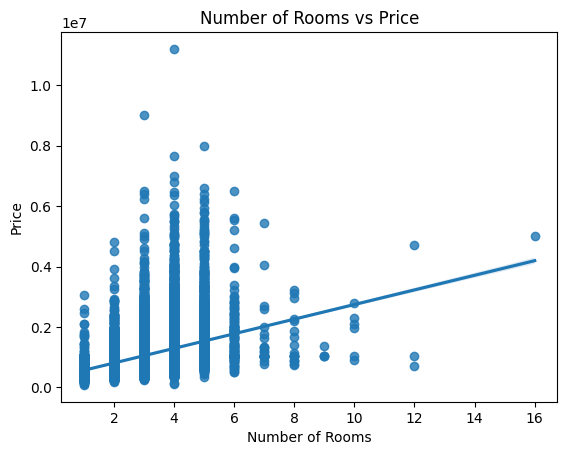

In [54]:
sns.regplot(x='Rooms',y='Price',data=housepricingdf)
plt.title("Number of Rooms vs Price") #Add plot title
plt.ylabel("Price") #Adjust the label of the y-axis
plt.xlabel("Number of Rooms") 
plt.show()

Text(0.5, 1.0, 'Correlation Graph of the Melbourne Dataset')

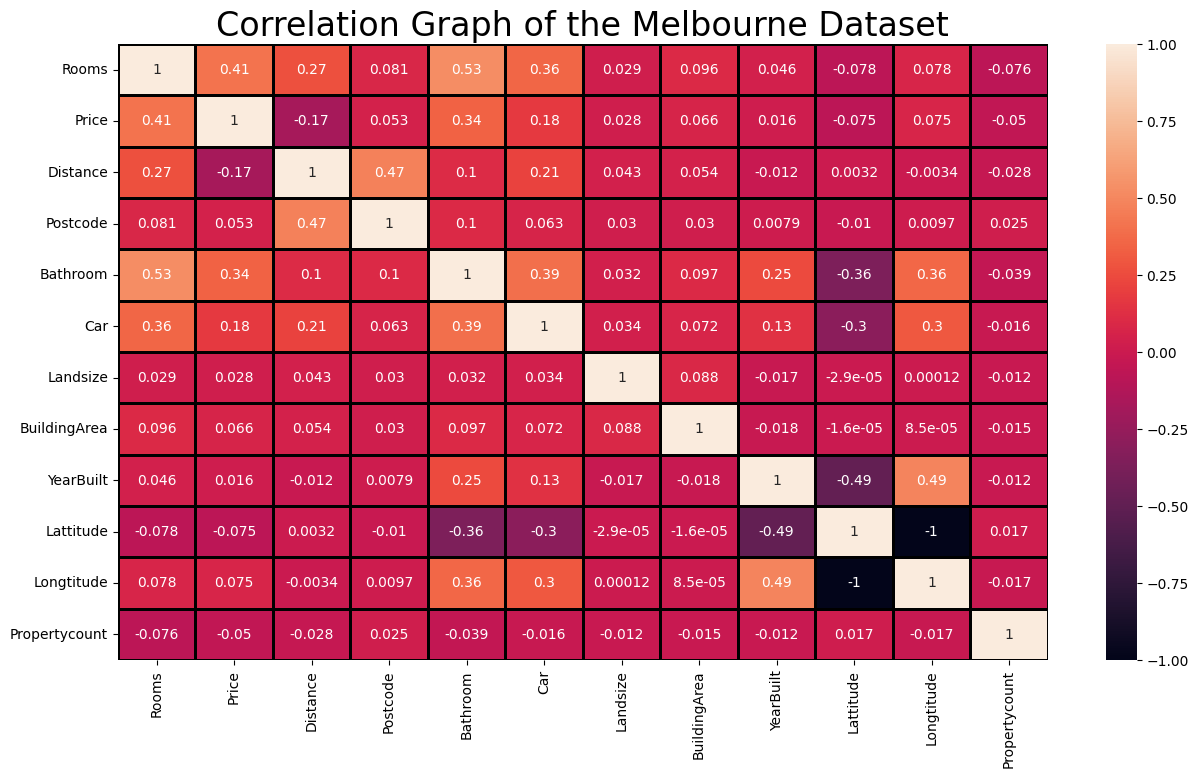

In [55]:
# Correlation Analysis of the Dataset
plt.figure(figsize=(15, 8))
correlation = sns.heatmap(housepricingdf.corr(), vmin=-1, vmax=1, annot=True, linewidths=1, linecolor='black')
correlation.set_title('Correlation Graph of the Melbourne Dataset', fontdict={'fontsize': 24})